In [14]:
# ============================================
# IMPORTS
# ============================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [15]:

# ============================================
# 1. CHARGEMENT ET FUSION DES DONNÉES
# ============================================
tracks = pd.read_csv("supervised_music_challenge_data/tracks.tsv", sep="\t", dtype={"track_id": str})
echonest = pd.read_csv("supervised_music_challenge_data/echonest_features.tsv", sep="\t", dtype={"track_id": str})
spectral = pd.read_csv("supervised_music_challenge_data/spectral_features.tsv", sep="\t", dtype={"track_id": str})
genres = pd.read_csv("supervised_music_challenge_data/genres.csv")

# Nettoyage noms colonnes
def clean_cols(df):
    df.columns = (df.columns
                 .str.lower()
                 .str.strip()
                 .str.replace(" ", "_")
                 .str.replace("-", "_")
                 .str.replace(r"[^a-zA-Z0-9_]", "", regex=True))
    return df

tracks = clean_cols(tracks)
echonest = clean_cols(echonest)
spectral = clean_cols(spectral)
genres = clean_cols(genres)

# Fusion
df = tracks.merge(echonest, on="track_id", how="left") \
          .merge(spectral, on="track_id", how="left")

# Conversion genres
df["genres"] = df["genres"].apply(ast.literal_eval)
df["genres_all"] = df["genres_all"].apply(ast.literal_eval)

# Dictionnaire id -> nom
id_to_name = dict(zip(genres["genre_id"], genres["genre_title"]))
def ids_to_names(id_list):
    return [id_to_name.get(i, "UNKNOWN") for i in id_list]

df["genres_names"] = df["genres"].apply(ids_to_names)
df["genres_all_names"] = df["genres_all"].apply(ids_to_names)

print(f"✓ Dataset fusionné: {len(df)} lignes, {df.shape[1]} colonnes")


✓ Dataset fusionné: 99995 lignes, 45 colonnes


In [16]:
# ============================================
# 2. NETTOYAGE DES DONNÉES
# ============================================
print("\n" + "="*60)
print("NETTOYAGE DES DONNÉES")
print("="*60)

# Supprimer duration <= 0
df_clean = df[df['duration'] > 0].copy()

# Traiter tempo = 0
df_clean.loc[df_clean['tempo'] == 0, 'tempo'] = np.nan

print(f"Dataset initial: {len(df)} lignes")
print(f"Dataset nettoyé: {len(df_clean)} lignes ({(len(df_clean)/len(df)*100):.1f}%)")
print(f"Lignes supprimées: {len(df) - len(df_clean)}")

# Sauvegarder
df_clean.to_csv("tracks_cleaned.csv", index=False)
print("Sauvegardé: tracks_cleaned.csv")



NETTOYAGE DES DONNÉES
Dataset initial: 99995 lignes
Dataset nettoyé: 99991 lignes (100.0%)
Lignes supprimées: 4
Sauvegardé: tracks_cleaned.csv



ANALYSE QUALITÉ DES DONNÉES

--- VALEURS MANQUANTES (top 10) ---
                  Count  Percentage
speechiness       89583   89.591063
valence           89459   89.467052
tempo             89457   89.465052
danceability      89457   89.465052
liveness          89438   89.446050
acousticness      89438   89.446050
instrumentalness  89438   89.446050
energy            89438   89.446050
artist_longitude  59786   59.791381
artist_latitude   59786   59.791381


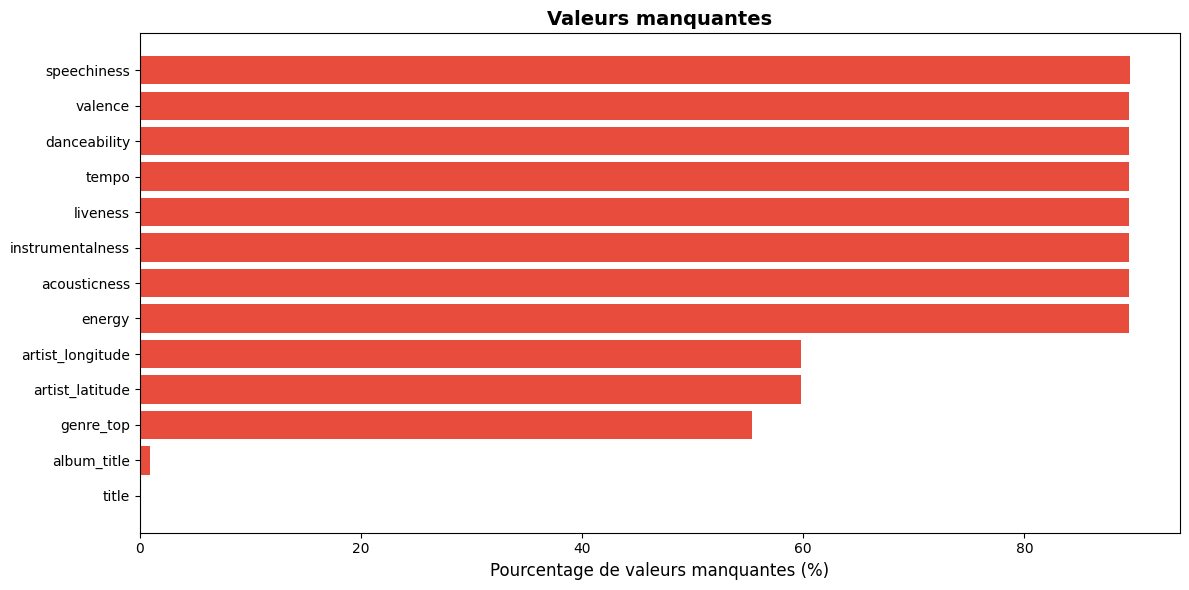

In [17]:
# ============================================
# 3. ANALYSE DE LA QUALITÉ DES DONNÉES
# ============================================
print("\n" + "="*60)
print("ANALYSE QUALITÉ DES DONNÉES")
print("="*60)

# Valeurs manquantes
missing = df_clean.isnull().sum()
missing_pct = (missing / len(df_clean)) * 100
missing_df = pd.DataFrame({
    'Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)

print("\n--- VALEURS MANQUANTES (top 10) ---")
print(missing_df[missing_df['Count'] > 0].head(10))

# Graphique missing values
if (missing_df['Count'] > 0).sum() > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    missing_to_plot = missing_df[missing_df['Percentage'] > 0].sort_values('Percentage')
    ax.barh(missing_to_plot.index, missing_to_plot['Percentage'], color='#e74c3c')
    ax.set_xlabel('Pourcentage de valeurs manquantes (%)', fontsize=12)
    ax.set_title('Valeurs manquantes', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [18]:
# ============================================
# 4. STATISTIQUES DESCRIPTIVES
# ============================================
print("\n" + "="*60)
print("STATISTIQUES DESCRIPTIVES")
print("="*60)

# Variables principales
numeric_cols = ['duration', 'listens', 'interest', 'favorites', 'tempo',
                'acousticness', 'danceability', 'energy', 'instrumentalness',
                'liveness', 'speechiness', 'valence']

print(df_clean[numeric_cols].describe())

# Duration par genre
if df_clean['genre_top'].notna().sum() > 0:
    print("\n--- DURATION PAR GENRE ---")
    print(df_clean[df_clean['genre_top'].notna()].groupby('genre_top')['duration'].describe())



STATISTIQUES DESCRIPTIVES
           duration        listens      interest     favorites         tempo  \
count  99991.000000   99991.000000  9.999100e+04  99991.000000  10534.000000   
mean     278.045644    2402.971797  3.628530e+03      3.240002    122.667999   
std      294.940936    8234.228670  1.957890e+04     13.864146     34.568381   
min        1.000000       0.000000  2.000000e+00      0.000000     12.753000   
25%      151.000000     305.000000  6.020000e+02      0.000000     95.880250   
50%      218.000000     797.000000  1.333000e+03      1.000000    120.027000   
75%      307.000000    2085.000000  3.116000e+03      3.000000    143.997500   
max    11030.000000  543252.000000  3.293557e+06   1482.000000    251.072000   

       acousticness  danceability        energy  instrumentalness  \
count  1.055300e+04  10534.000000  10553.000000      10553.000000   
mean   4.893790e-01      0.506784      0.541650          0.628853   
std    3.847813e-01      0.189812      0.2747

In [19]:

# ============================================
# 5. CORRÉLATIONS AVEC DURATION (Task 3)
# ============================================
print("\n" + "="*60)
print("CORRÉLATIONS AVEC DURATION")
print("="*60)

features_for_regression = ['listens', 'interest', 'favorites', 'tempo',
                           'acousticness', 'danceability', 'energy', 
                           'instrumentalness', 'liveness', 'speechiness', 'valence']

corr_with_duration = df_clean[features_for_regression + ['duration']].corr()['duration'].sort_values(ascending=False)
print(corr_with_duration)

# Top features
print("\n Features les plus corrélées positivement:")
for feat, val in corr_with_duration[corr_with_duration > 0].drop('duration').head(3).items():
    print(f"  - {feat}: {val:.3f}")



CORRÉLATIONS AVEC DURATION
duration            1.000000
liveness            0.095047
instrumentalness    0.073963
acousticness        0.022888
interest           -0.017817
favorites          -0.023377
speechiness        -0.023464
listens            -0.024108
tempo              -0.056969
energy             -0.092312
danceability       -0.120590
valence            -0.205061
Name: duration, dtype: float64

 Features les plus corrélées positivement:
  - liveness: 0.095
  - instrumentalness: 0.074
  - acousticness: 0.023


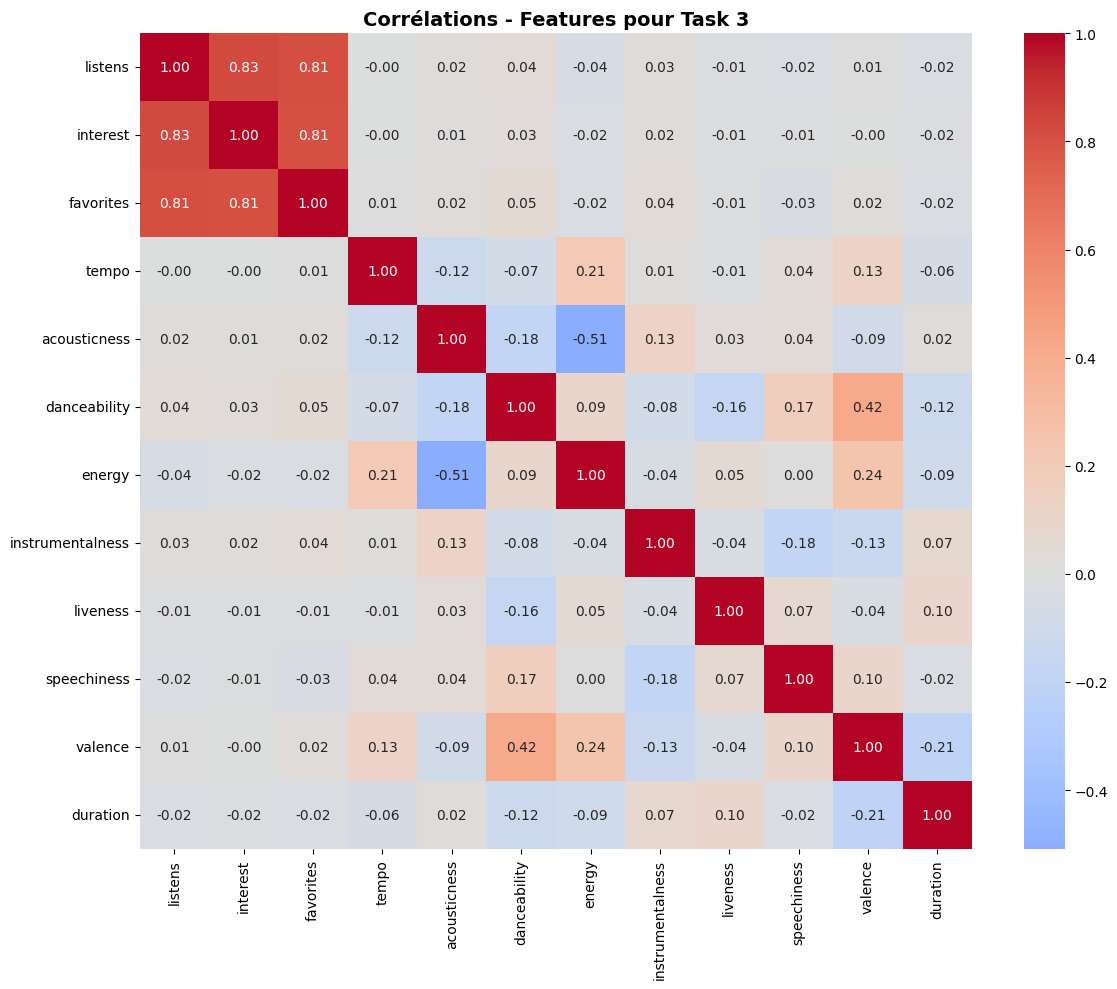

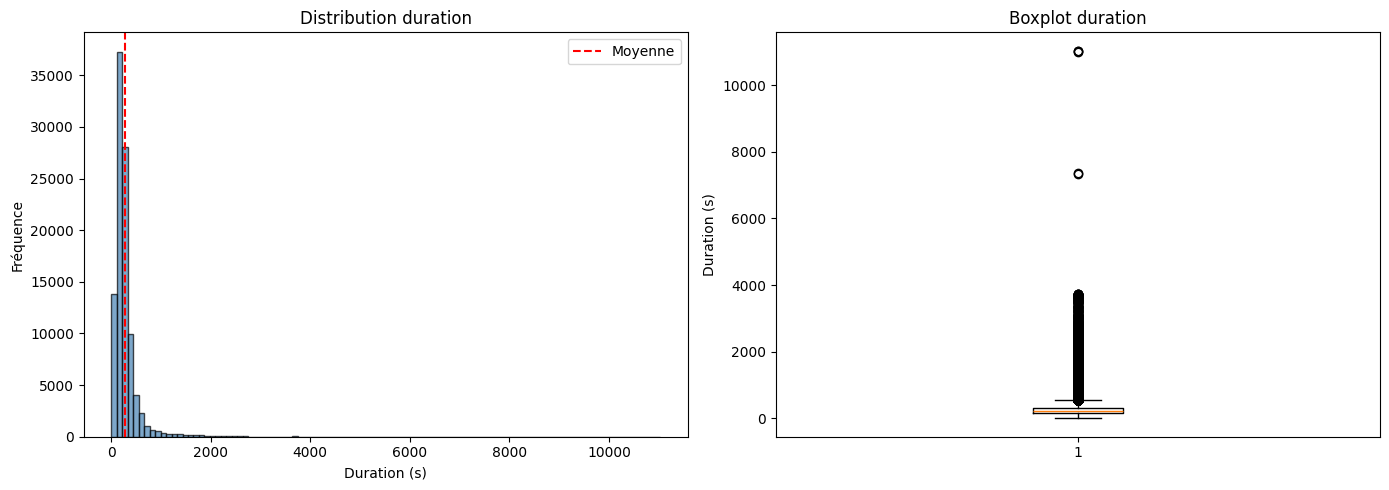

fin de PHASE 1 


In [20]:
# ============================================
# 6. VISUALISATIONS
# ============================================

# Heatmap corrélations
fig, ax = plt.subplots(figsize=(12, 10))
corr_matrix = df_clean[features_for_regression + ['duration']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
plt.title('Corrélations - Features pour Task 3', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Distribution duration
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df_clean['duration'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Duration (s)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution duration')
axes[0].axvline(df_clean['duration'].mean(), color='red', linestyle='--', label='Moyenne')
axes[0].legend()

axes[1].boxplot(df_clean['duration'])
axes[1].set_ylabel('Duration (s)')
axes[1].set_title('Boxplot duration')
plt.tight_layout()
plt.show()

print("fin de PHASE 1 ")

In [21]:
# ------TASK 3 : INITIALISATION --------

print("="*60)
print("TASK 3 - RÉGRESSION DURÉE (PRÉPARATION)")
print("="*60)

# 1. Charger dataset nettoyé (Phase 1)
try:
    df_clean = pd.read_csv("tracks_cleaned.csv")
except FileNotFoundError:
    # Au cas où, on reprend le df de la mémoire si le fichier n'est pas là
    df_clean = df.copy()

# 2. Target
y = df_clean['duration']

# 3. Définir les configurations de features (Listes seulement)
# -----------------------------------------------------------

# CONFIG 1 : Metadata only
metadata_features = ['listens', 'interest', 'favorites', 'album_tracks']
# Sécurité : on ne garde que celles qui existent vraiment dans le fichier
metadata_features = [c for c in metadata_features if c in df_clean.columns]

# CONFIG 2 : Audio features only (Echonest)
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                  'liveness', 'speechiness', 'tempo', 'valence']

# CONFIG 3 : Audio + Spectral features (combiné)
# On récupère toutes les colonnes qui contiennent 'spectral'
spectral_features = [col for col in df_clean.columns if 'spectral' in col]
combined_features = audio_features + spectral_features # Concaténation des listes

# 4. Organisation pour la suite
# On stocke tout dans un dictionnaire pour pouvoir faire une boucle propre après
feature_sets = {
    'Metadata Only': metadata_features,
    'Audio Only': audio_features,
    'Combined (Audio + Spectral)': combined_features
}

# Affichage de vérification
print(f"\n--- CONFIGURATIONS DÉFINIES ---")
for name, feats in feature_sets.items():
    print(f"Set '{name}' : {len(feats)} variables")

print(f"\n--- ÉTAT DES DONNÉES ---")
print(f"Nombre total de lignes : {len(df_clean)}")
print("Note : L'imputation des valeurs manquantes sera gérée par le Pipeline pour éviter le Data Leakage.")

TASK 3 - RÉGRESSION DURÉE (PRÉPARATION)

--- CONFIGURATIONS DÉFINIES ---
Set 'Metadata Only' : 4 variables
Set 'Audio Only' : 8 variables
Set 'Combined (Audio + Spectral)' : 29 variables

--- ÉTAT DES DONNÉES ---
Nombre total de lignes : 99991
Note : L'imputation des valeurs manquantes sera gérée par le Pipeline pour éviter le Data Leakage.


In [22]:
# ============================================
# FEATURE ENGINEERING (Création de variables)
# ============================================
print("\n" + "="*60)
print("FEATURE ENGINEERING (Calcul de nouvelles variables)")
print("="*60)

# On travaille sur une copie pour sécuriser
df_fe = df_clean.copy()

# 1. Interactions Mathématiques (Utile pour aider les modèles linéaires)
# Note : Si une valeur est NaN, le résultat sera NaN (sera géré par l'imputer plus tard)
df_fe['energy_tempo'] = df_fe['energy'] * df_fe['tempo']
df_fe['energy_danceability'] = df_fe['energy'] * df_fe['danceability']
df_fe['valence_energy'] = df_fe['valence'] * df_fe['energy']

# 2. Ratios (On ajoute +1e-3 pour éviter la division par zéro)
df_fe['energy_acousticness_ratio'] = df_fe['energy'] / (df_fe['acousticness'] + 1e-3)

# 3. Popularité Composite (Basée sur les Metadata - souvent complètes)
# C'est une excellente idée pour capturer la "notoriété" globale
df_fe['popularity_score'] = (
    df_fe['listens'] * 0.5 + 
    df_fe['interest'] * 2.0 + 
    df_fe['favorites'] * 5.0
)
# Transformation Log pour réduire l'impact des valeurs extrêmes (très écoutées)
df_fe['popularity_log'] = np.log1p(df_fe['popularity_score'])

# 4. Variables Binaires (Drapeaux)
# Ici, on doit gérer les NaN immédiatement sinon le True/False devient ambigu.
# On considère que si c'est NaN, ce n'est PAS instrumental (0) par défaut.
df_fe['is_instrumental'] = (df_fe['instrumentalness'].fillna(0) > 0.5).astype(int)
df_fe['is_live'] = (df_fe['liveness'].fillna(0) > 0.8).astype(int)

# 5. Agrégation Spectrale (Moyennes simples)
# Réduire la dimensionnalité des features spectrales est une bonne pratique
spectral_cols = [c for c in df_clean.columns if 'spectral' in c]
if spectral_cols:
    # On calcule la moyenne des colonnes de chaque type
    df_fe['spectral_bandwidth_avg'] = df_fe[[c for c in spectral_cols if 'bandwidth' in c]].mean(axis=1)
    df_fe['spectral_centroid_avg'] = df_fe[[c for c in spectral_cols if 'centroid' in c]].mean(axis=1)
    df_fe['spectral_rolloff_avg'] = df_fe[[c for c in spectral_cols if 'rolloff' in c]].mean(axis=1)

# Mise à jour du DataFrame principal pour la suite
df_work = df_fe.copy()

print(f"✓ Feature Engineering terminé.")
print(f"  Nouvelles variables créées : popularity_log, energy_tempo, is_instrumental, etc.")
print(f"  Total colonnes : {df_work.shape[1]}")


FEATURE ENGINEERING (Calcul de nouvelles variables)
✓ Feature Engineering terminé.
  Nouvelles variables créées : popularity_log, energy_tempo, is_instrumental, etc.
  Total colonnes : 56


In [23]:
# ============================================
# 3. MISE À JOUR DES LISTES & SPLIT TRAIN/TEST
# ============================================

# A. Mise à jour des listes de features avec les nouvelles variables créées
# -------------------------------------------------------------------------
# On ajoute les nouvelles variables aux bonnes listes
metadata_features_extended = metadata_features + ['popularity_log'] # On ajoute la popularité aux metadata

# Pour l'audio, on ajoute les interactions et les booléens
audio_features_extended = audio_features + [
    'energy_tempo', 'energy_danceability', 'valence_energy', 
    'energy_acousticness_ratio', 'is_instrumental', 'is_live'
]

# Pour le spectral, on ajoute les moyennes calculées
spectral_features_extended = spectral_features + [
    'spectral_bandwidth_avg', 'spectral_centroid_avg', 'spectral_rolloff_avg'
]

# On recrée le dictionnaire de configurations final
feature_sets = {
    'Metadata Only': [c for c in metadata_features_extended if c in df_work.columns],
    'Audio Only': [c for c in audio_features_extended if c in df_work.columns],
    'Combined (All)': [c for c in (metadata_features_extended + audio_features_extended + spectral_features_extended) if c in df_work.columns]
}

print(f"\n--- LISTES DE FEATURES MISES À JOUR ---")
for name, cols in feature_sets.items():
    print(f"  {name}: {len(cols)} variables")


# B. Split Train/Test (Sur le DataFrame brut)
# -------------------------------------------
# On sépare les données AVANT tout traitement (Scaling, Imputation) pour garantir l'intégrité du test.
# C'est la recommandation stricte du cours "Fondamentaux".

X = df_work # Contient toutes les colonnes
y = df_work['duration']

# Utilisation des index pour garder la trace
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"\n--- TRAIN/TEST SPLIT (GLOBAL) ---")
print(f"  Train set : {len(X_train_full)} lignes")
print(f"  Test set  : {len(X_test_full)} lignes")
print("  Note : Le Scaling et l'Imputation se feront automatiquement dans la boucle d'entraînement.")


--- LISTES DE FEATURES MISES À JOUR ---
  Metadata Only: 5 variables
  Audio Only: 14 variables
  Combined (All): 43 variables

--- TRAIN/TEST SPLIT (GLOBAL) ---
  Train set : 69993 lignes
  Test set  : 29998 lignes
  Note : Le Scaling et l'Imputation se feront automatiquement dans la boucle d'entraînement.


In [ ]:
# ============================================
# 4. MODÉLISATION ET ÉVALUATION (BOUCLE FINALE)
# ============================================

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

print("\n" + "="*60)
print("DÉBUT DE L'ENTRAÎNEMENT DES MODÈLES")
print("="*60)

# Définition des Pipelines
# ------------------------
# Chaque pipeline contient :
# 1. Imputer : Remplit les NaN (par la médiane du train set)
# 2. Scaler : Met les données à la même échelle (obligatoire pour SVM/KNN)
# 3. Model : L'algorithme de prédiction

def get_pipelines():
    # Étape de pré-traitement commune
    preprocess = [
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
    
    pipelines = {
        # Modèles simples (Baseline)
        'LinearRegression': Pipeline(preprocess + [('model', LinearRegression())]),
        'KNN (k=10)': Pipeline(preprocess + [('model', KNeighborsRegressor(n_neighbors=10))]),
        
        # Modèles avancés (Demandés par le sujet)
        'SVM (RBF)': Pipeline(preprocess + [('model', SVR(kernel='rbf', C=100, epsilon=0.1))]),
        
        # Méthodes d'Ensemble (Les plus performantes généralement)
        'RandomForest': Pipeline(preprocess + [
            ('model', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
        ]),
        'GradientBoosting': Pipeline(preprocess + [
            ('model', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42))
        ])
    }
    return pipelines

# Boucle d'exécution
# ------------------
results_data = []

# On itère sur chaque configuration de features (Metadata, Audio, Combined)
# feature_sets a été défini à l'étape précédente
for config_name, feature_list in feature_sets.items():
    
    print(f"\nTraitement de la configuration : {config_name} ...")
    
    # On sélectionne les colonnes correspondantes dans le split global créé à l'étape 3
    # Attention : on utilise X_train_full et X_test_full définis juste avant
    X_train_sub = X_train_full[feature_list]
    X_test_sub = X_test_full[feature_list]
    
    # On récupère des modèles neufs
    models = get_pipelines()
    
    for model_name, pipeline in models.items():
        # Entraînement
        pipeline.fit(X_train_sub, y_train)
        
        # Prédiction
        y_pred = pipeline.predict(X_test_sub)
        
        # Évaluation
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Stockage
        results_data.append({
            'Configuration': config_name,
            'Model': model_name,
            'RMSE': rmse,
            'R2': r2
        })

# Affichage des résultats finaux
# -----------------------------
results_df = pd.DataFrame(results_data)

# Tri par performance (R2 décroissant)
results_df = results_df.sort_values(by='R2', ascending=False)

print("\n" + "="*60)
print("CLASSEMENT FINAL DES PERFORMANCES")
print("="*60)
print(results_df.to_string(index=False))

# Identification du gagnant
best = results_df.iloc[0]
print(f"\n🏆 MEILLEUR MODÈLE : {best['Model']} ({best['Configuration']})")
print(f"   R² = {best['R2']:.4f}")
print(f"   RMSE = {best['RMSE']:.2f} secondes")

# Visualisation (Optionnel mais recommandé pour le rapport)
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Configuration', y='R2', hue='Model')
plt.title('Comparaison des performances (R²)')
plt.xticks(rotation=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


DÉBUT DE L'ENTRAÎNEMENT DES MODÈLES

Traitement de la configuration : Metadata Only ...
